# Radiative Transfer: RADMC-3D

[RADMC-3D](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/) is a Monte Carlo Radiative Transfer software package for astrophysics. The purpose of `dustpylib.radtrans.radmc3d` is to produce `RADMC-3D` input files from `DustPy` simulations.  
For details on the usage of `RADMC-3D` please have a look at the [RADMC-3D documentation](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/index.html).

This module creates axisymmetric disk models where the dust particles are vertically distributed according their scale heights. Dust pacities are created using the [dsharp_opac](https://github.com/birnstiel/dsharp_opac/) package ([Birnstiel et al., 2018](https://doi.org/10.3847/2041-8213/aaf743)).  
The intent of this module is not to provide a fully customizable interface to `RADMC-3D`, but more to provide a minimum working setup, that can be further customized manually.

In this notebook we are going to produce `RADMC-3D` images from the [planetary gaps example](https://stammler.github.io/dustpy/example_planetary_gaps.html) of the `DustPy` documentation. The repository contains a reduced `DustPy` output file of the final snapshot of the example model only containing the fields that are required to produce the `RADMC-3D` model.  
Thas example contains the default `DustPy` setup with Jupiter and Saturn added at their current locations.

This notebook only demonstrates the usage of the `dustpylib` module. `RADMC-3D` has to be installed and executed manually.

All quantities are in CGS units.

In the first step we load the `DustPy` data file.

In [1]:
from dustpy import hdf5writer

In [2]:
writer = hdf5writer()
writer.datadir = "example_planetary_gaps"

In [3]:
data = writer.read.output(21)

## Creating the `RADMC-3D` model

We can now use `dustpylib.radtrans.radmc3d` to produce the model intput files. The `Model` class accepts either a `DustPy.Simulation` object directly or a namespace as returned by the `Writer.read.output()` method.

In [4]:
from dustpylib.radtrans import radmc3d

In [5]:
rt = radmc3d.Model(data)

The `Model` object contains several attributes, that can be modified, where by definition attibutes with trailing `_` are imported from the `DustPy` model, while the ones without are used in the `RADMC-3D` model, e.g. the grid.

The `RADMC-3D` model parameters are chosen reasonably, but can be customized if needed.  
Some scattering modes of `RADMC-3D` require both hemispheres ($\theta$-grid) of the disk and an azimuthal grid ($\varphi$-grid), while other modes can work with a single hemisphere and a single azimuthal cell. This module will by default create both hemispheres ($\theta$-grid from $0$ to $\pi$ with $128$ grid cells) and a coarse azimuthal grid ($\varphi$-grid from $0$ to $2\pi$ with $16$ grid cells).

In this notebook we are going to use [scattering mode 5](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/dustradtrans.html#five-modes-of-treating-scattering), which requires both hemispheres but does not require an azimuthal grid. We can therefore turn the azimuthal grid off, by only providing two grid cell interfaces.

In [6]:
import numpy as np

In [7]:
rt.phii_grid = np.array([0., 2.*np.pi])

The inner edge of the disk is directly illuminated by the star and typically the densest part of the disk and therefore optically thick. Because of this the radial grid of the `RADMC-3D` setup is slightly refined in the inner part.  
Note, that in this specific example the `DustPy` grid has be refined at the location of the planets, which will then be also the case in the default `RADMC-3D` model setup. Steeper slope means finer radial grid.

In [8]:
import dustpy.constants as c
import matplotlib.pyplot as plt

In [9]:
plt.rcParams["figure.dpi"] = 150.

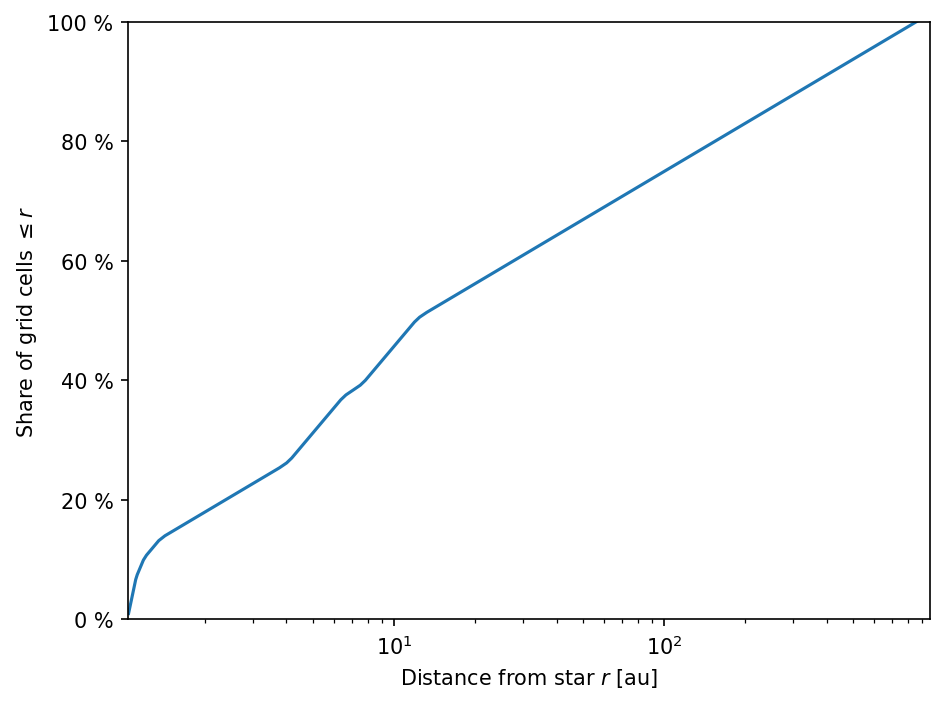

In [10]:
fig, ax = plt.subplots()
Ncells = rt.rc_grid.shape[0]
ax.semilogx(rt.rc_grid/c.au, np.linspace(1., 101., Ncells))
ax.set_xlabel("Distance from star $r$ [au]")
ax.set_ylabel("Share of grid cells $\leq r$")
ax.set_xlim(rt.ri_grid[0]/c.au, rt.ri_grid[-1]/c.au)
ax.set_ylim(0., 100.)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(["{:.0f} %".format(t) for t in ax.get_yticks()])
fig.tight_layout()

`DustPy` typically uses more particle species than one would want to use in radiative transfer models for performance reasons. By default this module uses only 16 dust species between the smallest and largest sizes in the `DustPy` setup. However, as can be seen in the [example notebook](https://stammler.github.io/dustpy/example_planetary_gaps.html) most of the larger bins are actually empty. It is therefore advisable to inspect the actual particle sizes and adjust the `RADMC-3D` size grid accordingly.

The largest particle are in the inner disk. We therefore have a look at the innermost `DustPy` grid cell.

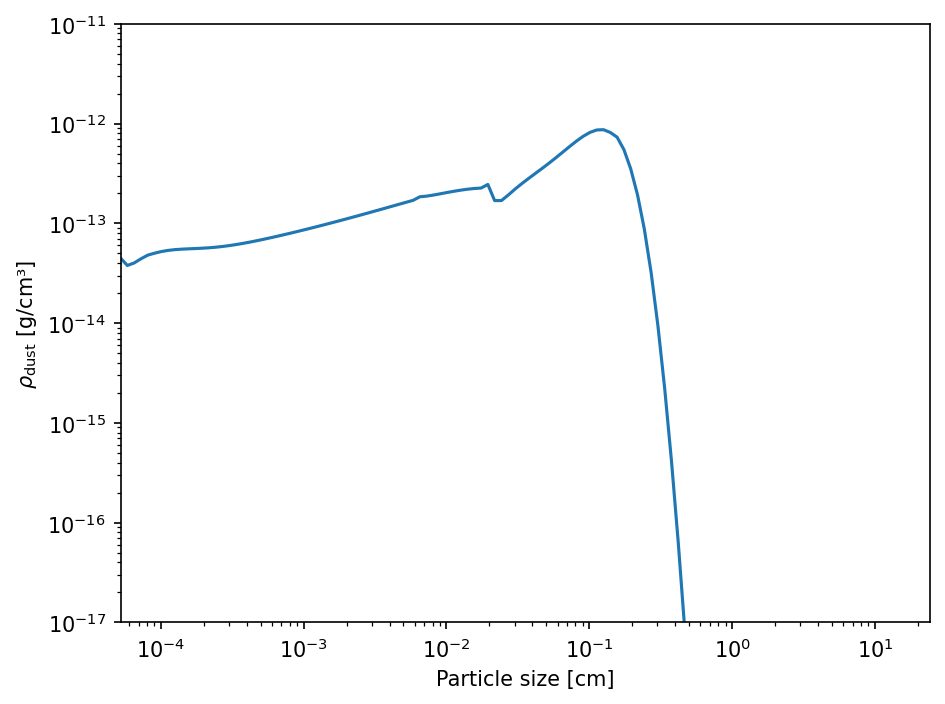

In [11]:
fig, ax = plt.subplots()
ax.loglog(rt.a_dust_[0, :], rt.rho_dust_[0, :])
ax.set_xlabel("Particle size [cm]")
ax.set_ylabel(r"$\rho_\mathrm{dust}$ [g/cm³]")
ax.set_xlim(rt.a_dust_.min(), rt.a_dust_.max())
ax.set_ylim(1.e-17, 1.e-11)
fig.tight_layout()

We therefore re-define the particle size grid of the `RADMC-3D` model with a maximum particle size of 1 cm. Note, that we have to set the interfaces of the size bins and there need 17 grid cell interfaces for 16 particle species.  
The hundreds of `DustPy` particle species will be re-binned onto this grid.

In [12]:
rt.ai_grid = np.geomspace(rt.a_dust_.min(), 1., 17)

The mean particle sizes of a size bin is automatically calculated.

In [13]:
rt.ac_grid

array([7.45574916e-05, 1.38067479e-04, 2.55676905e-04, 4.73469062e-04,
       8.76782175e-04, 1.62364776e-03, 3.00671264e-03, 5.56790773e-03,
       1.03107946e-02, 1.90937944e-02, 3.53583790e-02, 6.54775548e-02,
       1.21253018e-01, 2.24539455e-01, 4.15807933e-01, 7.70003814e-01])

The default wavelength grid will be cover wavelengths from $0.1\,\mu\mathrm{m}$ to $1\,\mathrm{cm}$ with a refinement around the $10\,\mu\mathrm{m}$ dust feature. The wavelength grid needs to cover those wavelengths at which the star mostly radiates and those wavelengths at which the dust particle predominantly cool. For hot stars ($\gtrsim 10\,000\,\mathrm{K}$) the wavelengths grid has to be extended to smaller wavelengths.

Note, that `RADMC-3D` uses microns for wavelengths. This module, however, uses exclusively CGS units and converts the quantities internally, if needed.

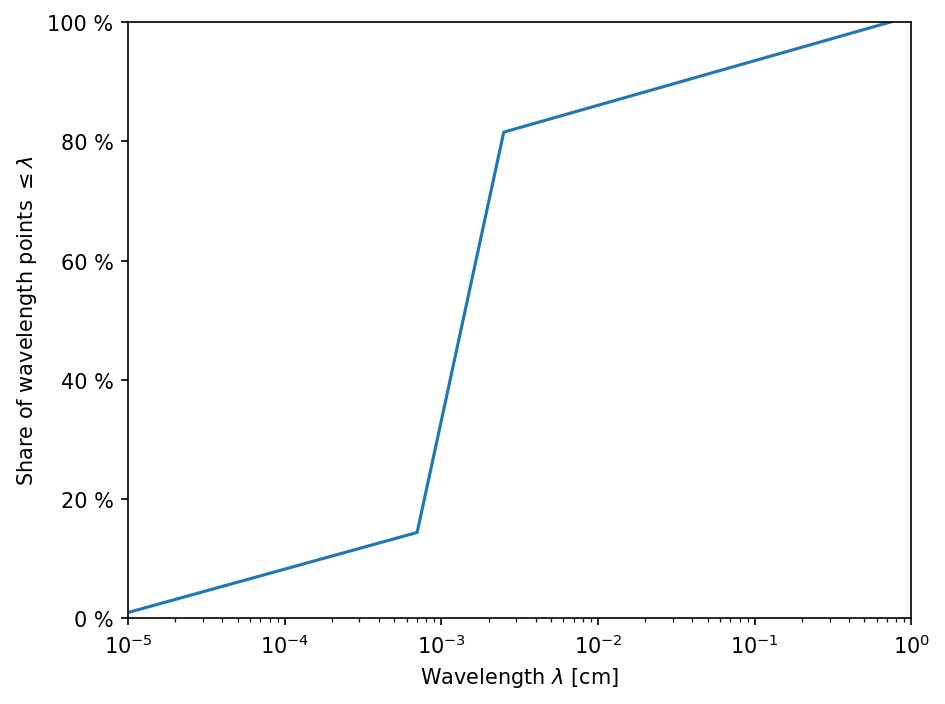

In [14]:
fig, ax = plt.subplots()
Ncells = rt.lam_grid.shape[0]
ax.semilogx(rt.lam_grid, np.linspace(1., 101., Ncells))
ax.set_xlabel("Wavelength $\lambda$ [cm]")
ax.set_ylabel("Share of wavelength points $\leq \lambda$")
ax.set_xlim(rt.lam_grid[0], rt.lam_grid[-1])
ax.set_ylim(0., 100.)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(["{:.0f} %".format(t) for t in ax.get_yticks()])
fig.tight_layout()

Additional options for the `radmc3d.inp` file can be added to the `radmc3d_options` dictionary.

In [15]:
rt.radmc3d_options

{'modified_random_walk': 1, 'iranfreqmode': 1, 'istar_sphere': 1}

We want to use $10\,000\,000$ photons for the thermal run, $1\,000\,000$ photons for the image run, and $10\,000$ for the spectral run.

In [16]:
rt.radmc3d_options["nphot"] = 10_000_000
rt.radmc3d_options["nphot_scat"] = 1_000_000
rt.radmc3d_options["nphot_spec"] = 10_000

The maximum optical depth of absorption at which photons get destroyed is by default $30$. In this notebook we want to decrease this values to $5$.

In [17]:
rt.radmc3d_options["mc_scat_maxtauabs"] = 5.

`dustpylib` will create opacity files that allow for the most complex scattering mode. In this notebook we want to use the largest possible mode. We therefore do not specify `scattering_mode_max`.

For the scattering we are using here `RADMC-3D` internally creates a $\varphi$-grid. To speed up the computation we want to reduce the number of grid cells from 360 to 60.

In [18]:
rt.radmc3d_options["dust_2daniso_nphi"] = 60

We want to store the `RADMC-3D` input files in the following directory

In [19]:
rt.datadir = "radmc3d"

To compute the dust opacities `dustpylib` uses the [dsharp_opac](https://github.com/birnstiel/dsharp_opac) package. Two different opacity models can be used: The DSHARP opacities (`Radmc3d.opacity=brinstiel2018`, [Birnstiel et al., 2018](https://doi.org/10.3847/2041-8213/aaf743), default) or the Ricci opacities (`Radmc3d.opacity=ricci2010`, [Ricci et al., 2010](https://doi.org/10.1051/0004-6361/200913403)). Please cite all references that are printed during the computations.

We can now create the `RADMC-3D` model files.

In [20]:
rt.write_files()

Writing radmc3d/radmc3d.inp.....done.
Writing radmc3d/stars.inp.....done.
Writing radmc3d/wavelength_micron.inp.....done.
Writing radmc3d/amr_grid.inp.....done.
Writing radmc3d/dust_density.inp.....done.
Writing radmc3d/dust_temperature.dat.....done.
Writing radmc3d/dustopac.inp.....done.

Computing opacities...
Using dsharp_opac. Please cite Birnstiel et al. (2018).
Using DSHARP mix. Please cite Birnstiel et al. (2018).
Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| 

/mnt/c/Users/sebas/physics/repos/dustpylib/dustpylib/radtrans/radmc3d/radmc3d.py:725: RuntimeWarning: invalid value encountered in double_scalars
  g[grain, i] = -2 * np.pi * np.trapz(zscat[grain, i, :, 0] * mu, x=mu) / k_sca[grain, i]



Writing radmc3d/dustkapscatmat_00.inp.....done.
Writing radmc3d/dustkapscatmat_01.inp.....done.
Writing radmc3d/dustkapscatmat_02.inp.....done.
Writing radmc3d/dustkapscatmat_03.inp.....done.
Writing radmc3d/dustkapscatmat_04.inp.....done.
Writing radmc3d/dustkapscatmat_05.inp.....done.
Writing radmc3d/dustkapscatmat_06.inp.....done.
Writing radmc3d/dustkapscatmat_07.inp.....done.
Writing radmc3d/dustkapscatmat_08.inp.....done.
Writing radmc3d/dustkapscatmat_09.inp.....done.
Writing radmc3d/dustkapscatmat_10.inp.....done.
Writing radmc3d/dustkapscatmat_11.inp.....done.
Writing radmc3d/dustkapscatmat_12.inp.....done.
Writing radmc3d/dustkapscatmat_13.inp.....done.
Writing radmc3d/dustkapscatmat_14.inp.....done.
Writing radmc3d/dustkapscatmat_15.inp.....done.


The `RADMC-3D` model is now ready to go. Of course, all files, especially `radmc3d.inp`, can be customized manually.

## Inspecting the `RADMC-3D` model

`dustpylib.radtrans.radmc3d` has a simple method to load the `RADMC-3D` model files to inspect the setup before executing `RADMC-3D`. It does only work for models created with `dustpylib` due to the assumed symmetries. For more [general methods for analyzing models](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/pythontools.html), use `radmc3dPy` that comes with `RADMC-3D`.

In [21]:
model = radmc3d.read_model(datadir="radmc3d")

We can now plot the densities of the `RADMC-3D` model.

In [22]:
def plot_model(model, radtrans, spec=-1):
    """
    Function plots the RADMC-3D model.
    
    Parameters
    ----------
    model : namespace
        The RADMC-3D model data
    radtrans : dustpylib.radtrans.radmc3d.Model
        The dustpylib model object. This is only needed
        to access the particle sizes, which are not stored
        in the RADMC-3D input files.
    spec : integer, optional, default : -1
        Particle species to be plotted. If -1, the total
        dust densities are plotted.
    """
    width = 6.
    height = width/1.3

    if spec==-1:
        rho = np.maximum(np.hstack((model.rho[:, :1, 0, :].sum(-1), model.rho[:, :, 0, :].sum(-1))), 1.e-100)
        T = np.hstack((model.T[:, :1, :, 0], model.T[:, :, :, 0])).mean(-1)
        a_rho = "total"
        a_T = "$a$ = {:.2e} cm".format(radtrans.ac_grid[0])
    else:
        rho = np.maximum(np.hstack((model.rho[:, :1, 0, spec], model.rho[:, :, 0, spec])), 1.e-100)
        T = np.hstack((model.T[:, :1, :, spec], model.T[:, :, :, spec])).mean(-1)
        a_rho = "$a$ = {:.2e} cm".format(radtrans.ac_grid[spec])
        a_T = "$a$ = {:.2e} cm".format(radtrans.ac_grid[spec])
                         
    rho = np.hstack((rho, np.flip(rho[:, 1:, ...], 1)))
    T = np.hstack((T, np.flip(T[:, 1:, ...], 1)))

    theta = np.hstack((model.grid.theta[0]-(model.grid.theta[1]-model.grid.theta[0]), model.grid.theta))
    theta = np.hstack((theta, theta[1:]+np.pi))
    lev_rho_max = np.ceil(np.log10(rho.max()))
    levels_rho = np.arange(lev_rho_max-6, lev_rho_max+1, 1.)

    fig, ax = plt.subplots(ncols=2, figsize=(2*width, height), subplot_kw={"projection": "polar"})

    p0 = ax[0].contourf(theta, model.grid.r/c.au, np.log10(rho), levels=levels_rho, extend="both", cmap="viridis")
    ax[0].contourf(-theta, model.grid.r/c.au, np.log10(rho), levels=levels_rho, extend="both", cmap="viridis")
    ax[0].set_theta_zero_location("N")
    ax[0].set_rlim(0)
    ax[0].set_rscale("symlog")
    ax[0].set_rgrids([1., 10., 100.], angle=-45)
    ax[0].tick_params(axis='y', colors='white')
    ax[0].set_xticks([])
    ax[0].plot(0., 0., "*", color="C3", markeredgewidth=0, markersize=12)
    cbar0 = plt.colorbar(p0)
    cbar0.set_ticks(cbar0.get_ticks())
    cbar0.set_ticklabels(["$10^{{{:d}}}$".format(int(t)) for t in cbar0.get_ticks()])
    cbar0.set_label(r"$\rho_\mathrm{dust}$ [g/cm³]")
    ax[0].set_title("Dust density, {}".format(a_rho))

    p1 = ax[1].contourf(theta, model.grid.r/c.au, T, extend="both", cmap="coolwarm")
    ax[1].contourf(-theta, model.grid.r/c.au, T, extend="both", cmap="coolwarm")
    ax[1].set_theta_zero_location("N")
    ax[1].set_rlim(0)
    ax[1].set_rscale("symlog")
    ax[1].set_rgrids([1., 10., 100.], angle=-45)
    ax[1].tick_params(axis='y', colors='black')
    ax[1].set_xticks([])
    ax[1].plot(0., 0., "*", color="C3", markeredgewidth=0, markersize=12)
    cbar1 = plt.colorbar(p1)
    cbar1.set_ticks(cbar1.get_ticks())
    cbar1.set_label(r"$T$ [K]")
    ax[1].set_title("Dust temperature, {}".format(a_T))

    fig.tight_layout()

This `dustpylib` modules creates the `dust_temperature.dat` file, which should be self-consistently calculated with `RADMC-3D`.  
However, `dustpylib` stores the temperatures that `DustPy` used during the simulation and assumes a vertically isothermal temperature and that all dust species have the same temperature as the gas. Note, the temperature in the plot does not look vertically isothermal due to a combination of the coarse $\theta$-grid and the logarithmic r-axis.

We can plot the total dust densities with `spec=-1`.

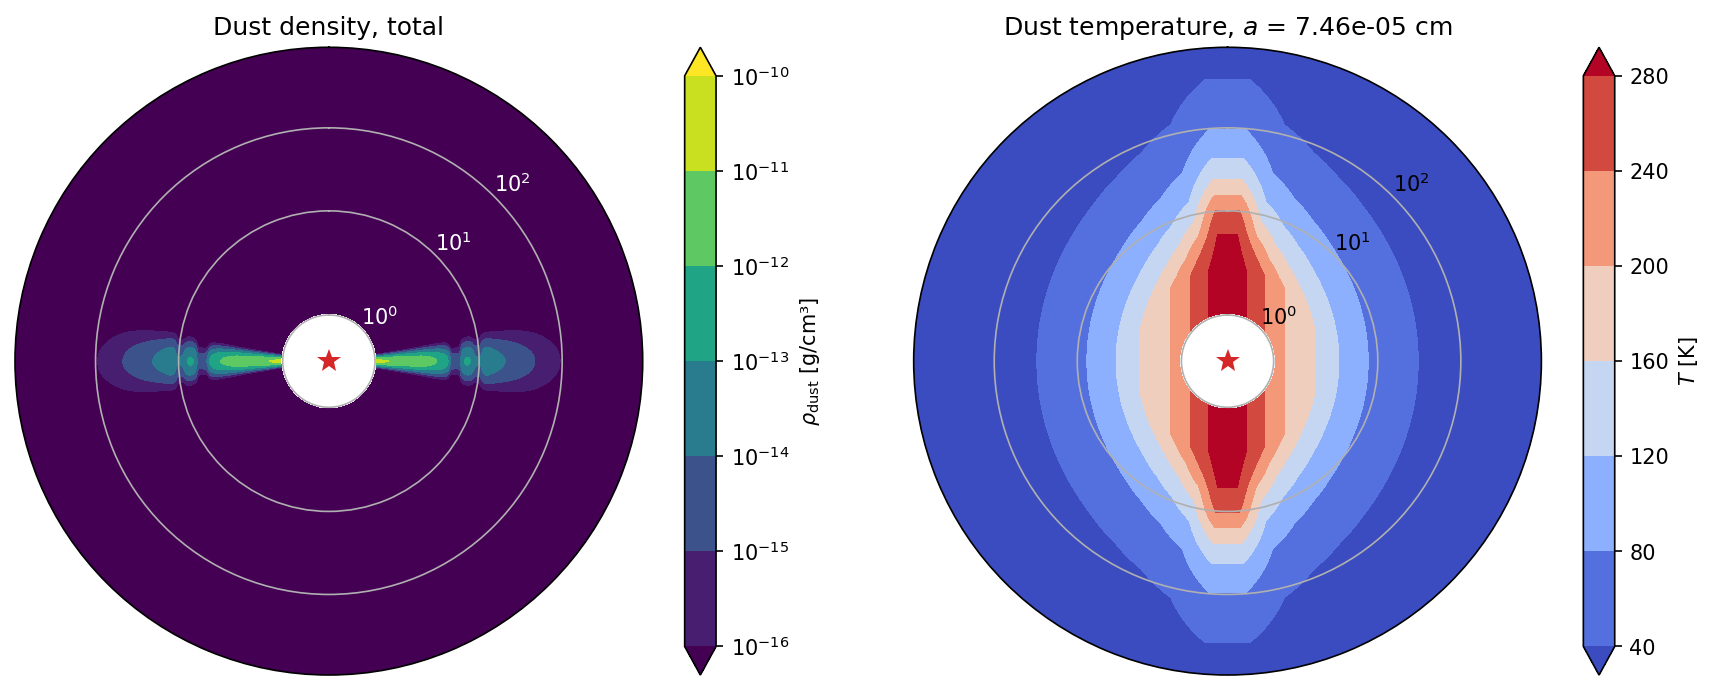

In [23]:
plot_model(model, rt, spec=-1)

Or plot specific dust species.

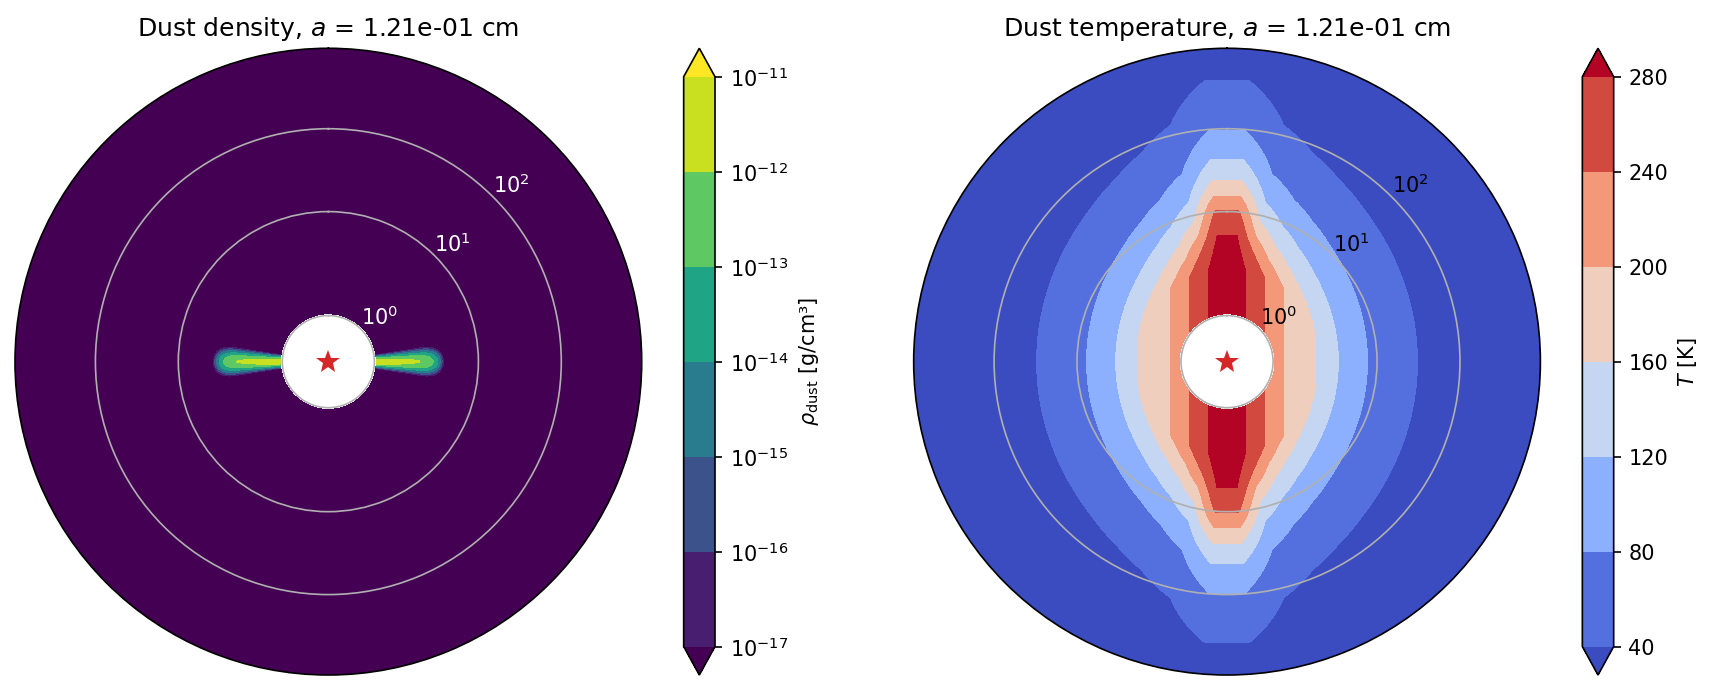

In [24]:
plot_model(model, rt, spec=12)

## Thermal Monte Carlo run

In the first step we run the thermal Monte Carlo process in which the dust temperatures are computed. This can be done by executing the following command in the directory with the `RADMC-3D` input files.

`radmc3d mctherm`

This will overwrite the `dust_temperature.dat` file with the temperatures self-consistently computed by `RADMC-3D`. To plot the new temperature we have to read the model files again.

In [25]:
model_mc = radmc3d.read_model(datadir="radmc3d")

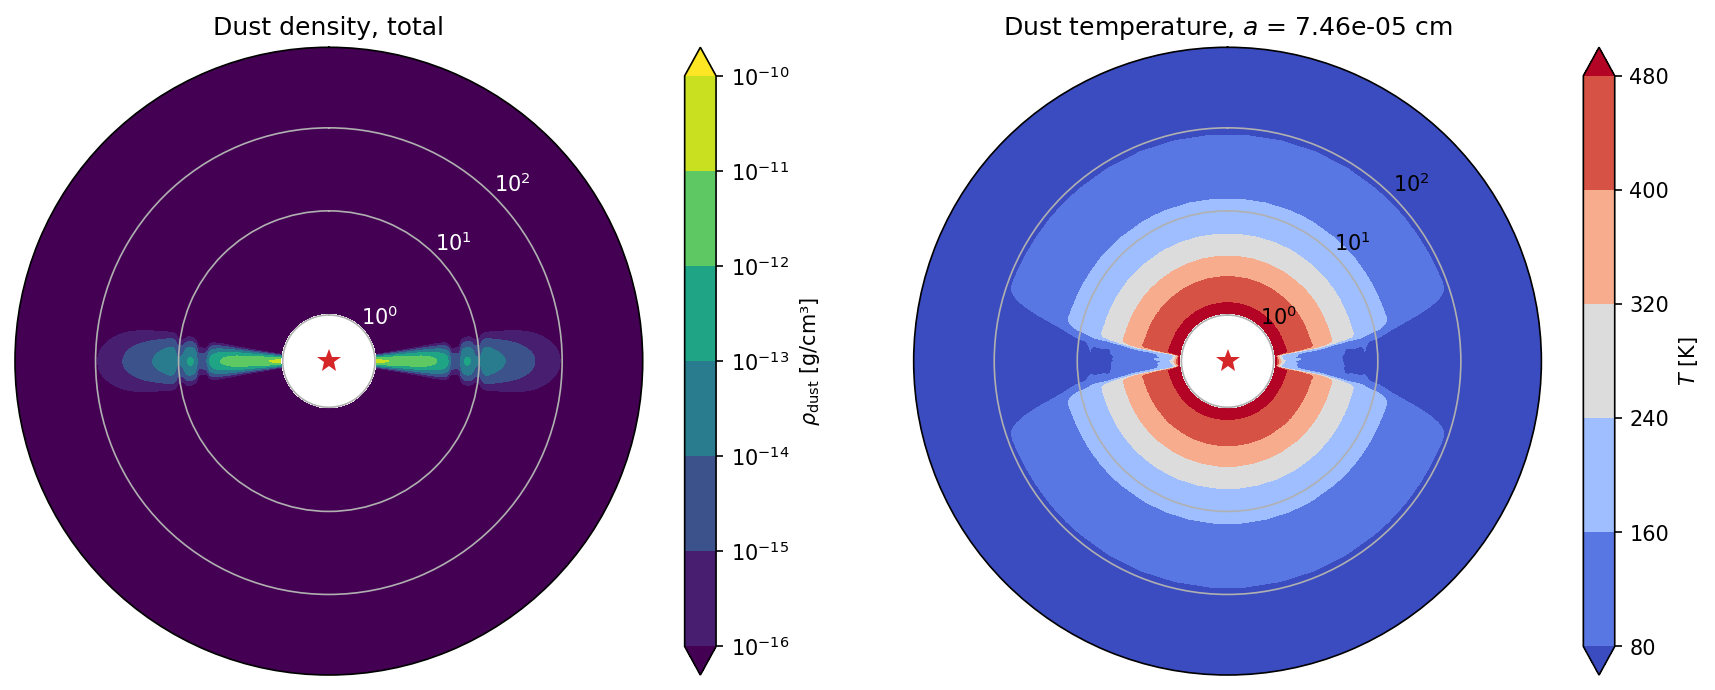

In [26]:
plot_model(model_mc, rt, spec=-1)

We can now compare the midplane temperature that `DustPy` uses with the temperatures that `RADMC-3D` calculated. We are taking the mean in azimuthal direction and we are taking the mean temperature of 5 grid cells above and below the midplane to reduce the Monte Carlo noise.

Note that the temperature at the inner edge of the disk is significantly increased in the `RADMC-3D` model, since it it directly illuminated by the star. `DustPy`, on the other hand, does not assume that the disk ends at the inner edge of the radial grid.

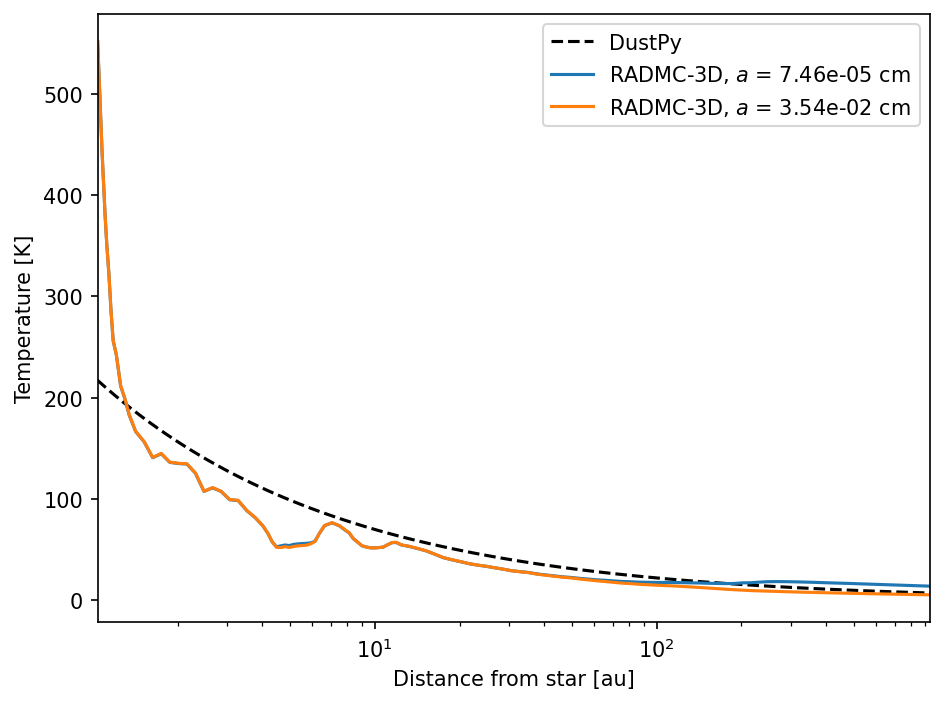

In [27]:
imid = int(model_mc.grid.theta.shape[0]/2)-1
irange = 5
fig, ax = plt.subplots()
ax.plot(data.grid.r/c.au, data.gas.T, "--", label="DustPy", c="black")
ax.plot(model_mc.grid.r/c.au, model_mc.T[:, imid-irange:imid+irange, :, 0].mean((-2, -1)), label="RADMC-3D, $a$ = {:.2e} cm".format(rt.ac_grid[0]))
ax.plot(model_mc.grid.r/c.au, model_mc.T[:, imid-irange:imid+irange, :, 10].mean((-2, -1)), label="RADMC-3D, $a$ = {:.2e} cm".format(rt.ac_grid[10]))
ax.set_xscale("log")
ax.set_xlim(model_mc.grid.r[0]/c.au, model_mc.grid.r[-1]/c.au)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Temperature [K]")
ax.legend()
fig.tight_layout()

## Creating radio images

We can now use `RADMC-3D` to create millimeter observations as obtained for example with [ALMA](https://www.eso.org/sci/facilities/alma/about-alma.html).

We are going to create two images: one at $\lambda = 0.88\,\mathrm{mm}$ (Band 7) and one at $\lambda = 1.3\,\mathrm{mm}$ (Band 6). Furthermore, we are focussing on the inner $100\,\mathrm{au}$ of the disk with 1024 pixels in both directions. This can be done with the following `RADMC-3D` command:

`radmc3d image lambdarange 880 1300 nlam 2 sizeau 100 npixx 1024 npixy 1024`

Afterwards we rename the image file with:

`mv image.out image_radio.out`

For more details have a look at the [imaging chapter](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/imagesspectra.html) of the `RADMC-3D` documentation.

We can now use `dustpylib` to load the image with the following helper function, which returns a dictionary.

In [28]:
image_radio = radmc3d.read_image("radmc3d/image_radio.out")

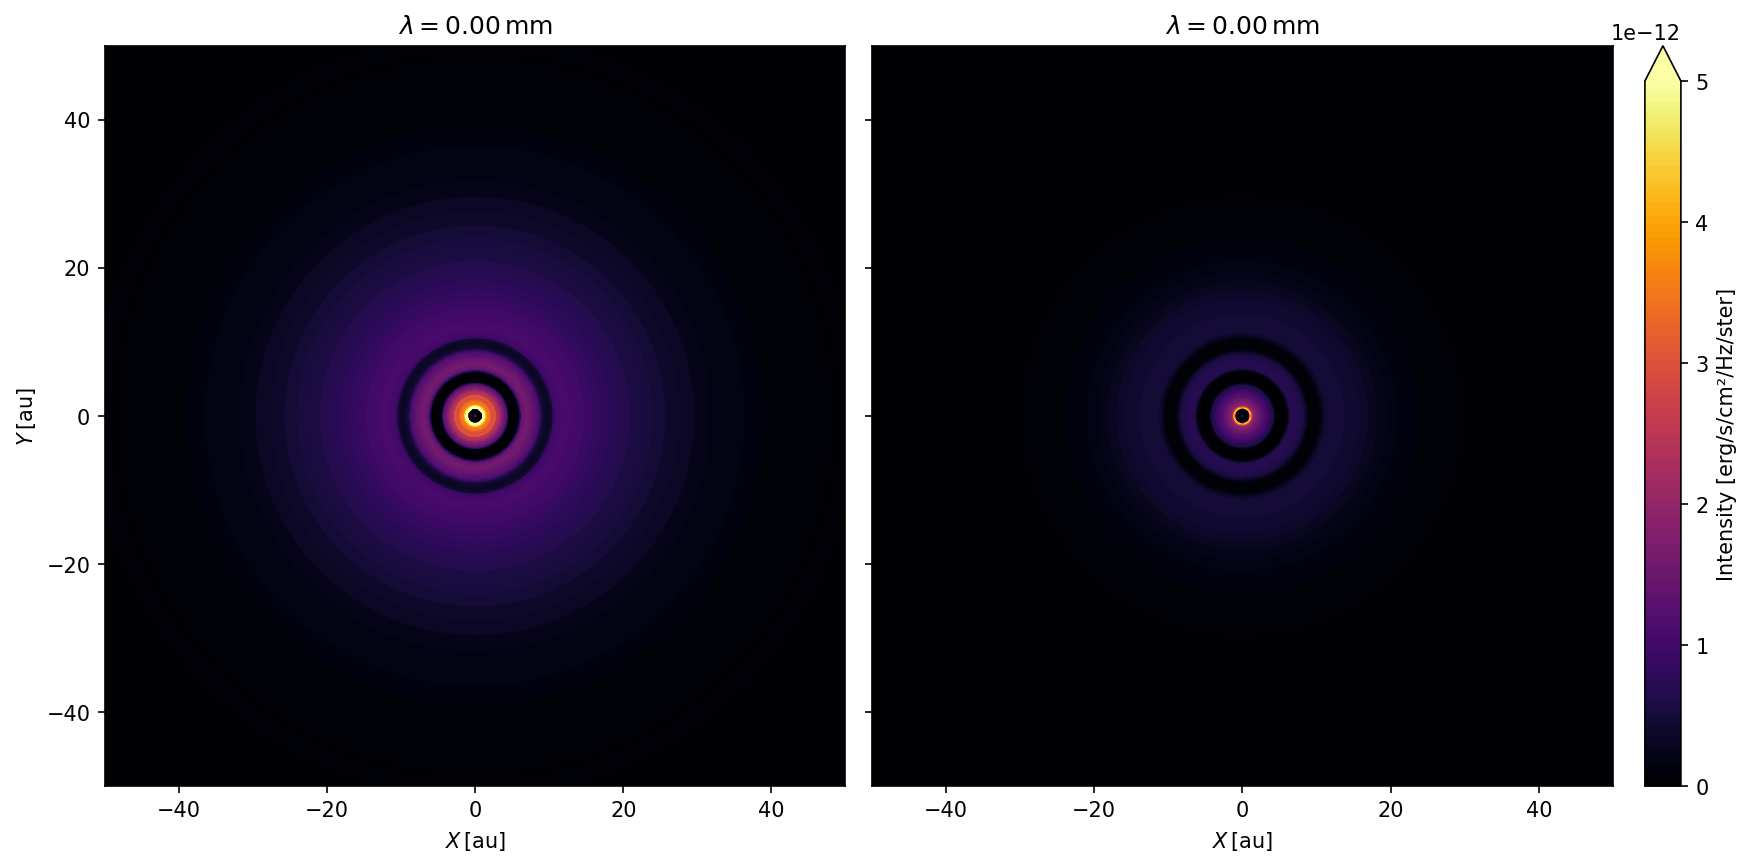

In [53]:
width = 6.
height = width
x, y = image_radio["x"]/c.au, image_radio["y"]/c.au
Imax = 0.5*image_radio["I"].max()
mag = np.floor(np.log10(Imax))
logmax = np.ceil(Imax * 10**(-mag))
levels = np.linspace(0., logmax, 100) * 10**mag
ticks = np.arange(int(logmax)+1) * 10**mag
fig, ax = plt.subplots(ncols=2, figsize=(2*width, height), sharey=True)
ax[0].set_aspect(1)
ax[0].contourf(x, y, image_radio["I"][..., 0].T, cmap="inferno", levels=levels, extend="max")
#ax[0].add_patch(plt.Circle((0, 0), 5.2, edgecolor="white", fill=False, linestyle="-", linewidth=1, alpha=0.5))
#ax[0].add_patch(plt.Circle((0, 0), 7.0, edgecolor="white", fill=False, linestyle="--", linewidth=1, alpha=0.5))
#ax[0].add_patch(plt.Circle((0, 0), 9.6, edgecolor="white", fill=False, linestyle="-", linewidth=1, alpha=0.5))
ax[0].set_title("$\lambda = {:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][0]*10.))
ax[0].set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
ax[0].set_ylabel(r"$Y\,\left[\mathrm{au}\right]$")
ax[1].set_aspect(1)
p = ax[1].contourf(x, y, image_radio["I"][..., 1].T, cmap="inferno", levels=levels, extend="max")
#ax[1].add_patch(plt.Circle((0, 0), 5.2, edgecolor="white", fill=False, linestyle="-", linewidth=1, alpha=0.5))
#ax[1].add_patch(plt.Circle((0, 0), 7.0, edgecolor="white", fill=False, linestyle="--", linewidth=1, alpha=0.5))
#ax[1].add_patch(plt.Circle((0, 0), 9.6, edgecolor="white", fill=False, linestyle="-", linewidth=1, alpha=0.5))
ax[1].set_title("$\lambda = {:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][1]*10.))
ax[1].set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
fig.tight_layout()
fig.subplots_adjust(right=0.9)
pos01 = ax[1].get_position()
cb_ax = fig.add_axes([1.02*pos01.x1, pos01.y0, 0.02, pos01.y1-pos01.y0])
cbar = fig.colorbar(p, cax=cb_ax)
cbar.set_ticks(ticks)
cbar.set_label(r"Intensity [erg/s/cm²/Hz/ster]")

Note that `RADMC-3D` comes with a Python support package to create `.fits` files from images which can the be processes with [CASA](https://almascience.eso.org/tools/casa-simulator).

We can furthermore plot the radial intensity profile.

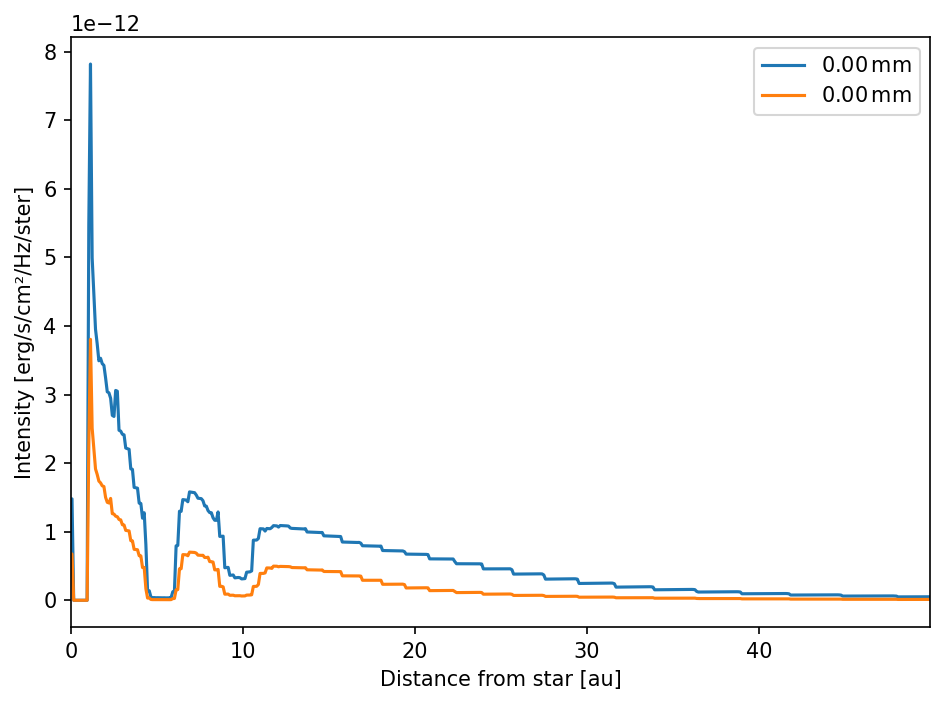

In [30]:
x = image_radio["x"]/c.au
Nx = x.shape[0]
fig, ax = plt.subplots()
ax.plot(x, image_radio["I"][:, int(Nx/2), 0], label="${:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][0]*10.))
ax.plot(x, image_radio["I"][:, int(Nx/2), 1], label="${:.2f}\,\mathrm{{mm}}$".format(image_radio["lambda"][1]*10.))
ax.set_xlim(0., x.max())
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel(r"Intensity [erg/s/cm²/Hz/ster]")
ax.legend()
fig.tight_layout()

## Investigating polarization

To create images with polarization information we have to append the `stokes` flag to the `RADMC-3D` command. We only do this here for a single wavelength

`radmc3d image lambda 880 sizeau 100 npixx 1024 npixy 1024 stokes`

and rename the image file

`mv image.out image_polarization.out`

In [31]:
image_polarization = radmc3d.read_image("radmc3d/image_polarization.out")

Now we can calculate the polarization fraction.

In [32]:
I, Q, U = image_polarization["I"], image_polarization["Q"], image_polarization["U"]
P = np.sqrt(Q**2+U**2)/I

Then we have to convert the Stokes-$Q$ and Stokes-$U$ into the directions of the electric fields. Details on this can be found int the `RADMC-3D` [documentation](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/dustradtrans.html#definitions-and-conventions-for-stokes-vectors).

In [33]:
chi = 0.5 * np.arctan(U/Q)
Ex = np.sin(chi)
Ey = np.cos(chi)

/tmp/ipykernel_13051/1789234742.py:1: RuntimeWarning: divide by zero encountered in true_divide
  chi = 0.5 * np.arctan(U/Q)


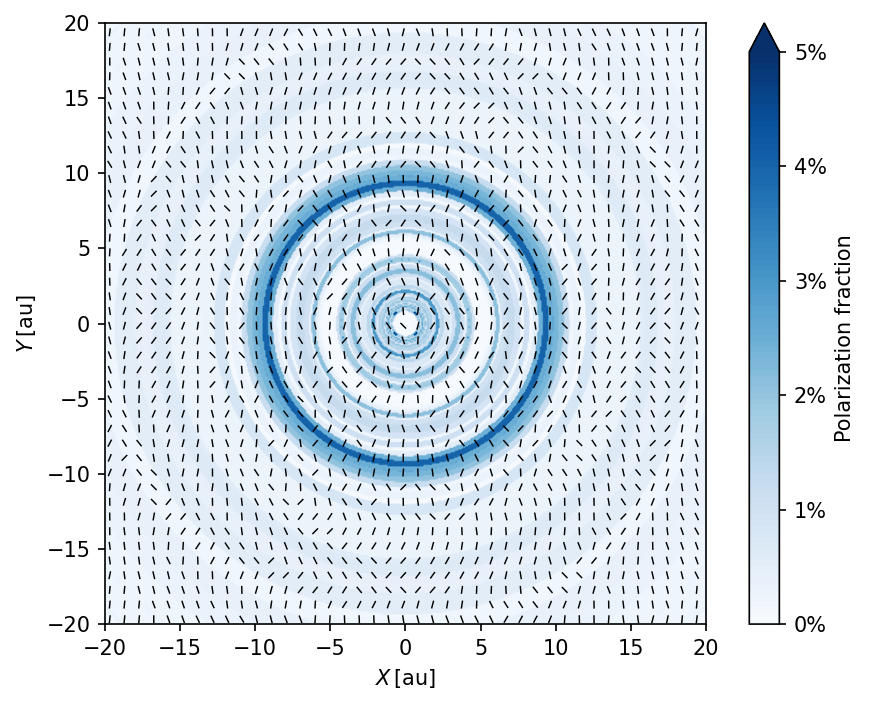

In [54]:
skip = 10
x, y = image_polarization["x"]/c.au, image_polarization["y"]/c.au
Qnorm = Q / (P*I)
Unorm = U / (P*I)
levels = np.linspace(0., 0.05, 100)
ticks = np.arange(0., 0.06, 0.01)
fig, ax = plt.subplots()
ax.set_aspect(1)
p = ax.contourf(x, y, P[..., 0].T, cmap="Blues", levels=levels, extend="max")
ax.quiver(x[::skip], y[::skip], Ex[::skip, ::skip, 0], Ey[::skip, ::skip, 0], pivot="mid", headwidth=0, headlength=0, headaxislength=0, color="black", scale=75)
#ax.add_patch(plt.Circle((0, 0), 5.2, edgecolor="C3", fill=False, linestyle="-", linewidth=1, alpha=1))
#ax.add_patch(plt.Circle((0, 0), 7.0, edgecolor="C3", fill=False, linestyle="--", linewidth=1, alpha=1))
#ax.add_patch(plt.Circle((0, 0), 9.6, edgecolor="C3", fill=False, linestyle="-", linewidth=1, alpha=1))
ax.set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
ax.set_ylabel(r"$Y\,\left[\mathrm{au}\right]$")
cbar = plt.colorbar(p)
cbar.set_ticks(ticks)
cbar.set_ticklabels(["{:.0f}%".format(t*100.) for t in cbar.get_ticks()])
cbar.set_label("Polarization fraction")
ax.set_xlim(-20., 20)
ax.set_ylim(-20., 20)
fig.tight_layout()

For more information on this polarization pattern, please have a look at [Kataoka et al. (2015)](https://doi.org/10.1088/0004-637X/809/1/78).

## Creating optical light images

While images at radio wavelengths typically trace the disk midplane, images at optical wavelengths, such as taken with [SPHERE](https://www.eso.org/sci/facilities/paranal/instruments/sphere.html) at the [VLT](https://www.eso.org/sci/facilities/paranal/telescopes.html) are heavily affected by scattering and therefore mostly trace the disk surface.

The approach is identical to the radio images. However, we additionally incline the disk and use a larger field of view to give a better impression of the three-dimensional disk. We are taking an image at $\lambda=1.6\,\mu\mathrm{m}$ with the following command

`radmc3d image lambda 1.6 sizeau 400 npixx 1024 npixy 1024 incl 60 posang 30`

and rename the image file

`mv image.out image_optical.out`

In [36]:
image_optical = radmc3d.read_image("radmc3d/image_optical.out")

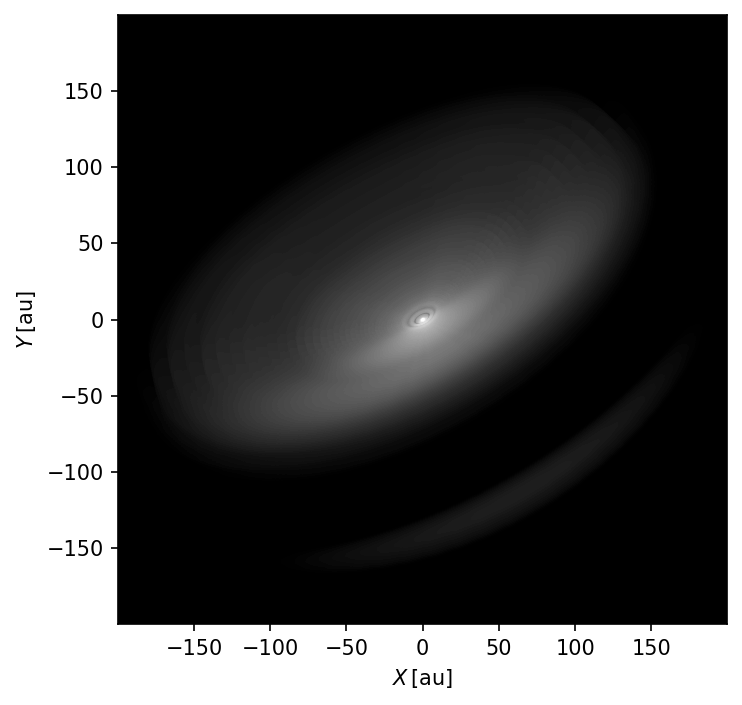

In [37]:
x, y = image_optical["x"]/c.au, image_optical["y"]/c.au
I = image_optical["I"]
Imax = image_optical["I"].max()
levmax = np.ceil(np.log10(Imax))-3
levels = np.linspace(levmax-6, levmax, 100)
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.contourf(x, y, np.log10(I[..., 0].T), cmap="gray", levels=levels, extend="both")
ax.set_xlabel(r"$X\,\left[\mathrm{au}\right]$")
ax.set_ylabel(r"$Y\,\left[\mathrm{au}\right]$")
fig.tight_layout()

The gaps created by the planets are barely visible in the inner part of the disk in this unconvolved image. Furhtermore, we can see the dark midplane at the disk edge and some light scattered from the other side of the disk.

## Creating spectra

To create spectra we can use the following command

`radmc3d sed`

This will create an SED at every wavelength point of the `RADMC-3D` model. This will take a while, since it is creating an image at every wavelengths point.  
`RADMC-3D` will return an SED from a distance of $1\,\mathrm{pc}$.

In [38]:
spectrum = radmc3d.read_spectrum("radmc3d/spectrum.out")

In [44]:
from astropy.modeling.models import BlackBody
import astropy.constants as ac
import astropy.units as u

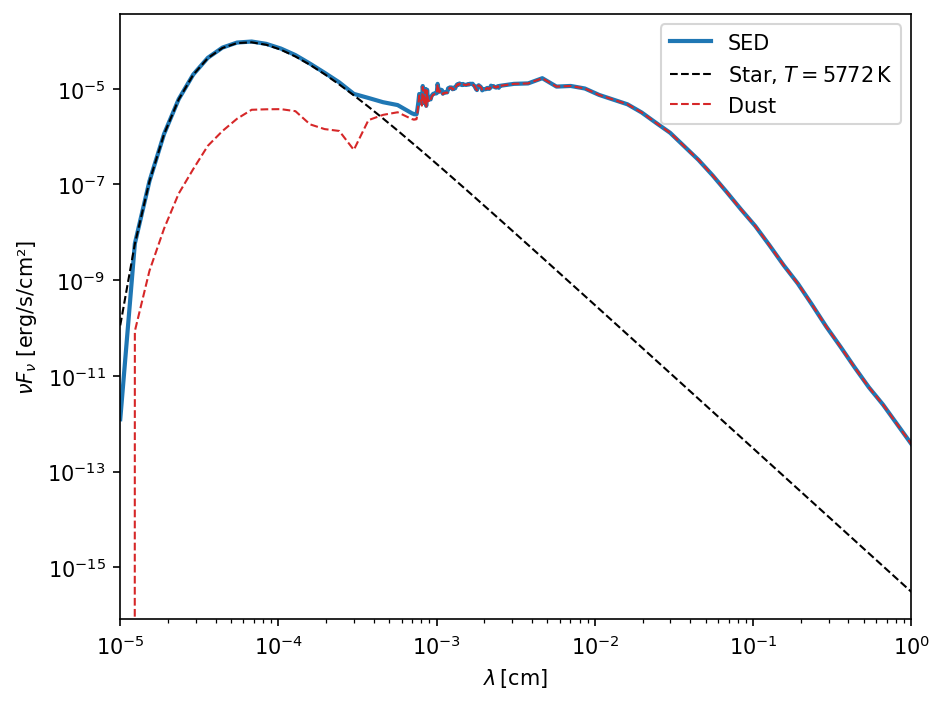

In [76]:
lam, F = spectrum["lambda"], spectrum["flux"]
nu = ac.c/(lam*u.cm)
bb = BlackBody(temperature=rt.T_star_*u.K)
conv = (np.pi * ((rt.R_star_*u.cm)/(1.*u.pc))**2.).cgs.value
star = nu.cgs.value*bb(lam*u.cm)*conv
dust = nu.cgs.value*F-star.cgs.value
fig, ax = plt.subplots()
ax.plot(lam, nu.cgs.value*F, label="SED", lw=2)
ax.plot(lam, star, c="black", lw=1, ls="--", label="Star, $T={:.0f}\,\mathrm{{K}}$".format(rt.T_star_))
ax.plot(lam, dust, c="C3", lw=1, ls="--", label="Dust")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(lam[0], lam[-1])
ax.set_xlabel(r"$\lambda\,\left[\mathrm{cm}\right]$")
ax.set_ylabel(r"$\nu F_\nu$ [erg/s/cm²]")
ax.legend()
fig.tight_layout()